In [2]:
import psycopg2, os
import hashlib as hl  
import multihash as mh

In [3]:
# query to connect to the postgresql db
postgres_connect_query="host=127.0.0.1 dbname=nebula user=nebula password=password"
# query to get all peers
get_peers_query="select id,multi_hash from peers;"
# query to retrieve all neighbors relations between peers
get_neighbors_query="select peer_id,neighbor_ids from neighbors where crawl_id=2;"

# indexes in the postgresql peers/neighbors db for multihashes and ids (topo id)
peers_id_col=0       # for both peers and neighbors query results
peers_mh_col=1       # for peers query results
neighbor_ids_col=1   # for neighbors query results

In [4]:
def bytes_to_bit_string(data: bytes) -> str:
    return "".join(f'{byte:08b}' for byte in data)
  
def multihash_to_kad_id(peer_id: str) -> bytes:  
    multi_hash = mh.from_b58_string(peer_id)
    return hl.sha256(multi_hash).digest()

def get_peer_list(cur) -> dict:
    cur.execute(get_peers_query)
    return {l[peers_id_col]: [multihash_to_kad_id(l[peers_mh_col]), l[peers_mh_col]] for l in cur.fetchall()}

# this should be a clean way (even if it could be done in less lines it is more readable)
def xor_distance(bytes0: bytes, bytes1: bytes):
    xor=bytearray()
    maxlen=max(len(bytes0), len(bytes1))

    for i in range(maxlen):
        byte0 = bytes0[i if len(bytes0)>len(bytes1) else i-len(bytes1)+len(bytes0)] if i >= maxlen-len(bytes0) else 0
        byte1 = bytes1[i if len(bytes1)>len(bytes0) else i-len(bytes0)+len(bytes1)] if i >= maxlen-len(bytes1) else 0
        xor.append(byte0 ^ byte1)

    return bytes(xor)

# get the corresponding k-bucket for the given XOR distance in bytes
def bucket_number_for_distance(d: bytes) -> int:
    count=0
    # iterate on the bytes from left to right
    for b in d:
        # while the byte==0, add 8 (bits) to the counter
        count+=8
        if b!=0:
            # at the first non null byte, shift right until this byte==0
            while b!=0:
                b>>=1
                # for each right shift, remove 1 to counter
                count-=1
            break
    # return the length of the byte string minus the number of leading 0 bits
    return 256-(8*len(d)-count)


##### TESTING METHODS #####

def bitstring_to_bytes(s):
    v = int(s, 2)
    b = bytearray()
    while v:
        b.append(v & 0xff)
        v >>= 8
    return bytes(b[::-1])

In [5]:
class Peer(object):

    def __init__(self, topo_id, kad_id, peer_id):
        self.topo_id=topo_id
        self.peer_id=peer_id
        self.kad_id=kad_id
        self.neighbors=[]
        self.buckets=[[] for _ in range(257)]
        
    def alive(self) -> bool:
        return len(neighbors)>0

    def distance(self, p):
        return xor_distance(self.kad_id, p.kad_id)

    def add_neighbor(self, p):
        self.neighbors.append(p)
        self.buckets[bucket_number_for_distance(self.distance(p))].append(p)


In [6]:
class Topology(object):

    def __init__(self):
        # query the nebula crawler
        self.conn = psycopg2.connect(postgres_connect_query)
        self.cur = self.conn.cursor()

        self.peer_list = get_peer_list(self.cur)

        # create all peers
        self.peers = {}
        for p in self.peer_list:
            self.peers[p]=(Peer(p,self.peer_list[p][0],self.peer_list[p][1]))

        # assign neighbors
        self.cur.execute(get_neighbors_query)
        neighbors_relations = self.cur.fetchall()
        for (p, neighbors) in neighbors_relations:
            for n in neighbors:
                # dirty fix
                if n in self.peers:
                    self.peers[p].add_neighbor(self.peers[n])

    def get_peers(self):
        return [p for p in self.peers]

    def peer_to_kad_id(self, p: str) -> bytes:
        return self.peers[p].kad_id

    # given 2 peers ids (not multihash), compute and return xor distance
    # between the 2 multihashes associated with the peers
    def xor_distance(self, p0: str, p1: str) -> bytes:
        return p0.distance(p1)
        #return xor_distance(self.peers[p0][0], self.peers[p1][0])
        #return int.from_bytes(xor_distance(self.peers[p0][0], self.peers[p1][0]), "big") # decimal representation of distance


    # bucket number is a bijective mapping
    def bucket_for_peers(self, p0: str, p1: str) -> int:
        return bucket_number_for_distance(self.xor_distance(p0, p1))

In [7]:
t = Topology()

OperationalError: connection to server at "127.0.0.1", port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?


In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
buckets=[[] for _ in range(257)]

no_neighbor_count=0
for pid in t.peers:
    p=t.peers[pid]
    if len(p.neighbors)<10:
        no_neighbor_count+=1
    else:
        for i in range(len(p.buckets)):
            buckets[i].append(len(p.buckets[i]))
            
print(no_neighbor_count)
# probably unreachable nodes
# test if neighbors in buckets are still alive

NameError: name 't' is not defined

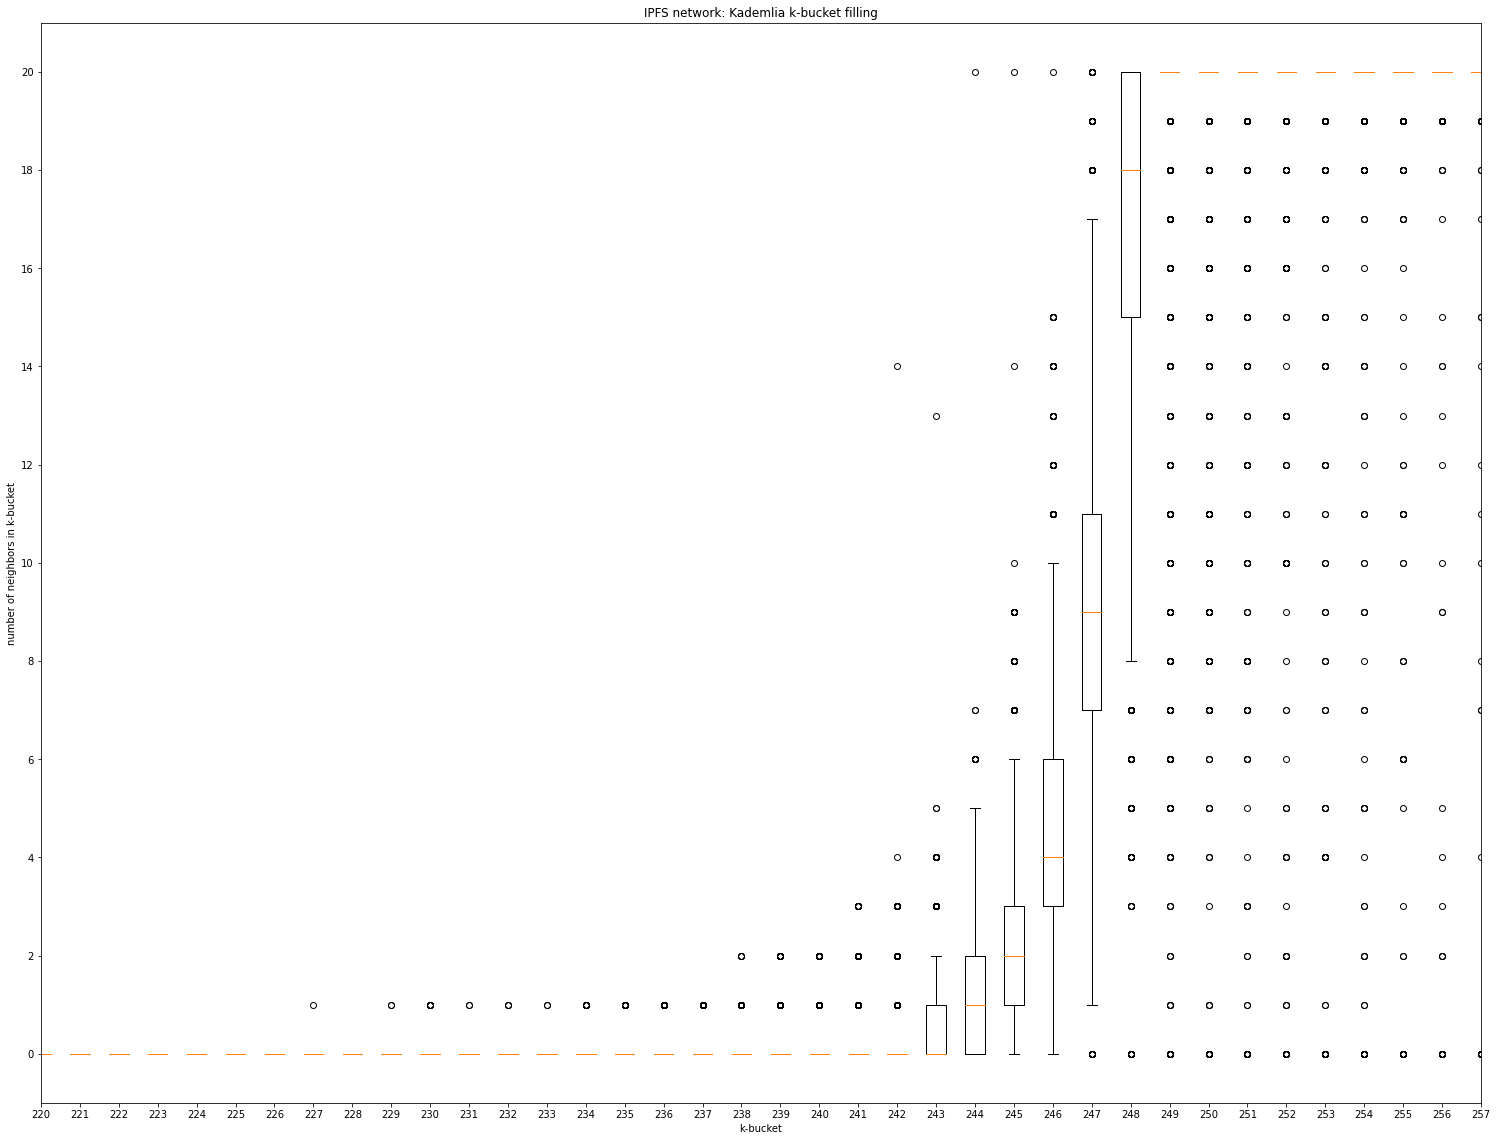

In [14]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_axes([0, 0, 1, 1])

ax.set_xlim(220,257)
plt.yticks(np.arange(0, 21, 2))

plt.xlabel("k-bucket")
plt.ylabel("number of neighbors in k-bucket")

plt.title("IPFS network: Kademlia k-bucket filling")

bp = ax.boxplot(buckets)
 
# show plot
plt.show()

In [15]:
unreachables=[]
for pid in t.peers:
    p=t.peers[pid]
    if len(p.neighbors)==0:
        unreachables.append(p)
        
print(len(t.peers))
print(len(t.peers)-len(unreachables))
print(len(unreachables))
print(15570/30453)

30453
15570
14883
0.5112796768791252


In [17]:
dead_neighbors=[0]*257

for pid in t.peers:
    p=t.peers[pid]
    if len(p.neighbors)>0:
        for i in range(len(p.buckets)):
            for n in p.buckets[i]:
                if n in unreachables:
                    dead_neighbors[i]+=1
                    
print(dead_neighbors)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 2, 4, 3, 7, 23, 41, 100, 155, 346, 727, 1403, 2778, 5726, 11393, 23156, 40239, 21970, 14098, 11489, 10941, 11602, 12650, 13798, 15119, 15132]


In [19]:
dead_neighbors_backup = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 2, 4, 3, 7, 23, 41, 100, 155, 346, 727, 1403, 2778, 5726, 11393, 23156, 40239, 21970, 14098, 11489, 10941, 11602, 12650, 13798, 15119, 15132]


In [24]:
bucket_sums=[0]*257

for i in range(257):
    for j in buckets[i]:
        bucket_sums[i]+=j
        
print(bucket_sums)
        

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 6, 2, 3, 2, 8, 33, 76, 135, 266, 522, 1020, 2217, 4380, 8404, 17091, 34791, 69299, 139856, 263070, 308165, 309600, 309960, 310220, 310421, 310613, 310676, 310821, 311010]


In [25]:
dead_ratio=[]
for i in range(257):
    if dead_neighbors[i]==0:
        dead_ratio.append(0)
    else:
        dead_ratio.append(dead_neighbors[i]/bucket_sums[i])
        
print(dead_ratio)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 1.0, 1.0, 0.5, 0.09090909090909091, 0.09210526315789473, 0.17037037037037037, 0.15413533834586465, 0.19157088122605365, 0.15196078431372548, 0.15606675687866486, 0.16598173515981735, 0.16694431223227035, 0.16254168860803933, 0.1645827944008508, 0.1644035267464177, 0.16557030088090607, 0.1529592884023263

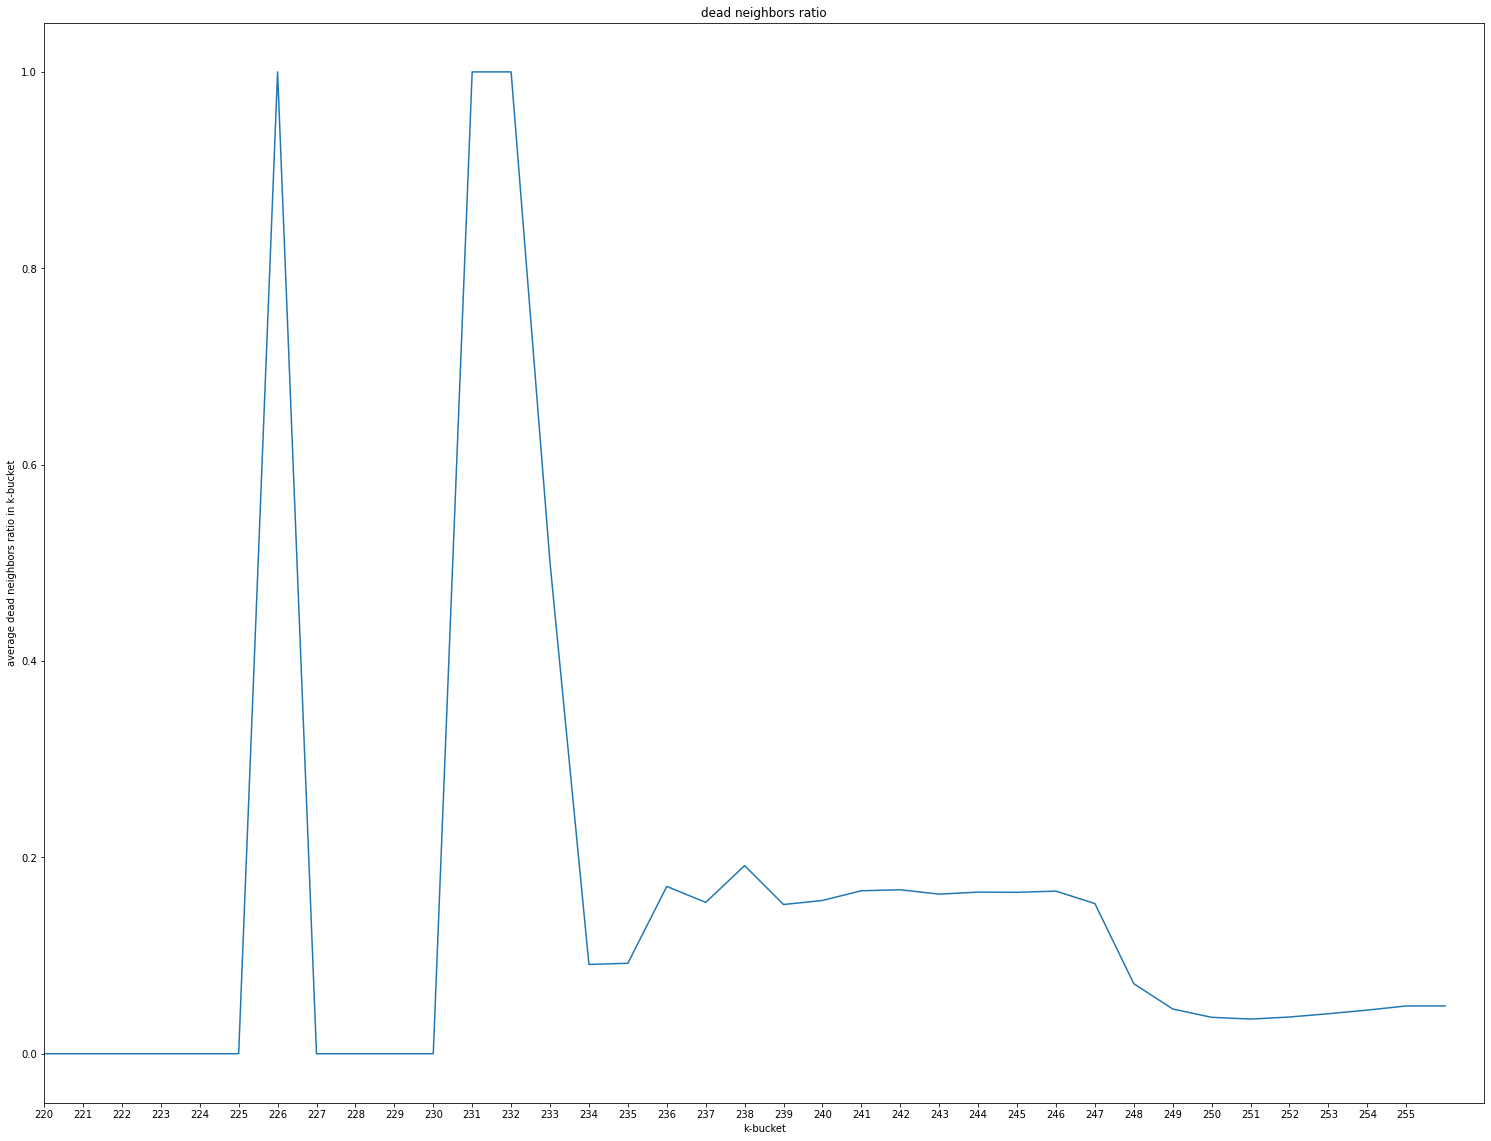

In [26]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_axes([0, 0, 1, 1])

plt.plot(dead_ratio)
ax.set_xlim(220,257)
plt.xticks(np.arange(220, 256, 1))
#ax.set_ylim(-0.05, 0.32)
#plt.yticks(np.arange(0, 0.3, 0.05))

plt.xlabel("k-bucket")
plt.ylabel("average dead neighbors ratio in k-bucket")

plt.title("dead neighbors ratio")
plt.show()